In [1]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

In [2]:
!gdown 178YSDYmlRh54IcxStgYA3UyKFRM9-3DO

Downloading...
From: https://drive.google.com/uc?id=178YSDYmlRh54IcxStgYA3UyKFRM9-3DO
To: /content/dataset.zip
100% 2.35M/2.35M [00:00<00:00, 141MB/s]


In [3]:
!unzip /content/dataset.zip -d /content/dataset

Archive:  /content/dataset.zip
   creating: /content/dataset/dataset/
  inflating: /content/dataset/dataset/weatherHistory.csv  


In [5]:
dataset_filepath = 'dataset/dataset/weatherHistory.csv'
df = pd.read_csv(dataset_filepath)
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [8]:
univariate_df = df['Temperature (C)']
univariate_df.index = df['Formatted Date']
univariate_df.head()

,Temperature (C)
Formatted Date,
2006-04-01 00:00:00.000 +0200,9.472222
2006-04-01 01:00:00.000 +0200,9.355556
2006-04-01 02:00:00.000 +0200,9.377778
2006-04-01 03:00:00.000 +0200,8.288889
2006-04-01 04:00:00.000 +0200,8.755556


In [9]:
input_size = 6
label_size = 1
offset = 1

def sliding_window(df, df_start_idx, df_end_idx, input_size, label_size, offset):
    features = []
    labels = []

    window_size = input_size + offset

    if df_end_idx == None:
        df_end_idx = len(df) - window_size

    for idx in range(df_start_idx, df_end_idx):
        feature_end_idx = idx + input_size
        label_start_idx = idx + window_size - label_size

        feature = df[idx:feature_end_idx]
        label = df[label_start_idx:(idx + window_size)]

        features.append(feature)
        labels.append(label)

    features = np.expand_dims(np.array(features), -1)
    labels = np.array(labels)

    return features, labels

In [10]:
dataset_length = len(univariate_df)
train_size = 0.7
val_size = 0.2
train_end_idx = int(train_size * dataset_length)
val_end_idx = int(val_size * dataset_length) + train_end_idx

X_train, y_train = sliding_window(
    univariate_df,
    df_start_idx = 0,
    df_end_idx = train_end_idx,
    input_size = input_size,
    label_size = label_size,
    offset = offset
)

X_val, y_val = sliding_window(
    univariate_df,
    df_start_idx = train_end_idx,
    df_end_idx = val_end_idx,
    input_size = input_size,
    label_size = label_size,
    offset = offset
)

X_test, y_test = sliding_window(
    univariate_df,
    df_start_idx = val_end_idx,
    df_end_idx = None,
    input_size = input_size,
    label_size = label_size,
    offset = offset
)

In [12]:
class WeatherForecast(Dataset):
    def __init__(
            self,
            X, y,
            transform = None
    ):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
            X = self.transform(X)

        X = torch.tensor(X, dtype = torch.float32)
        y = torch.tensor(y, dtype = torch.float32)

        return X, y

In [13]:
train_dataset = WeatherForecast(
    X_train, y_train
)
val_dataset = WeatherForecast(
    X_val, y_val
)
test_dataset = WeatherForecast(
    X_test, y_test
)

train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size = train_batch_size,
    shuffle = True
)
val_loader = DataLoader(
    val_dataset,
    batch_size = test_batch_size,
    shuffle = False
)
test_loader = DataLoader(
    test_dataset,
    batch_size = test_batch_size,
    shuffle = False
)

In [21]:
class WeatherForecastor(nn.Module):
    def __init__(self, embedding_dim, hidden_size, n_layers, dropout_prob):
        super(WeatherForecastor, self).__init__()
        self.rnn = nn.RNN(
            embedding_dim,
            hidden_size,
            n_layers,
            batch_first = True
        )
        self.norm = nn.LayerNorm(hidden_size)

        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x, hn = self.rnn(x)
        x = x[:, -1, :]
        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [22]:
embedding_dim = 1
hidden_size = 8
n_layers = 3
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = WeatherForecastor(
    embedding_dim,
    hidden_size,
    n_layers,
    dropout_prob
).to(device)

In [23]:
lr = 1e-3
epochs = 50

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)

In [24]:
def fit(
    model, train_loader, val_loader,
    criterion, optimizer, device, epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []
        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = np.mean(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader, criterion, device
        )
        val_losses.append(val_loss)
        print(f'EPOCH {epoch + 1}: Train loss {train_loss:.4f} Val loss: {val_loss:.4f}')

    return train_losses, val_losses

def evaluate(model, dataloader, criterion, device, ):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = np.mean(losses)
    val_acc = correct / total

    return val_loss, val_acc

In [25]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
)

EPOCH 1: Train loss 124.2067 Val loss: 41.6310
EPOCH 2: Train loss 29.0421 Val loss: 7.3289
EPOCH 3: Train loss 14.4439 Val loss: 3.2658
EPOCH 4: Train loss 11.3891 Val loss: 2.6907
EPOCH 5: Train loss 10.4993 Val loss: 1.9826
EPOCH 6: Train loss 10.0351 Val loss: 1.8885
EPOCH 7: Train loss 9.5388 Val loss: 1.7117
EPOCH 8: Train loss 9.1758 Val loss: 1.7398
EPOCH 9: Train loss 8.9873 Val loss: 1.9900
EPOCH 10: Train loss 8.9272 Val loss: 1.6401
EPOCH 11: Train loss 8.5584 Val loss: 1.8564
EPOCH 12: Train loss 8.4873 Val loss: 1.7922
EPOCH 13: Train loss 8.2469 Val loss: 1.9142
EPOCH 14: Train loss 7.9794 Val loss: 1.9972
EPOCH 15: Train loss 7.9152 Val loss: 1.8862
EPOCH 16: Train loss 7.8249 Val loss: 1.6664
EPOCH 17: Train loss 7.5482 Val loss: 1.7403
EPOCH 18: Train loss 7.4008 Val loss: 1.9411
EPOCH 19: Train loss 7.3597 Val loss: 1.6128
EPOCH 20: Train loss 7.1854 Val loss: 1.5331
EPOCH 21: Train loss 7.0211 Val loss: 1.7825
EPOCH 22: Train loss 6.9163 Val loss: 1.5498
EPOCH 23: T

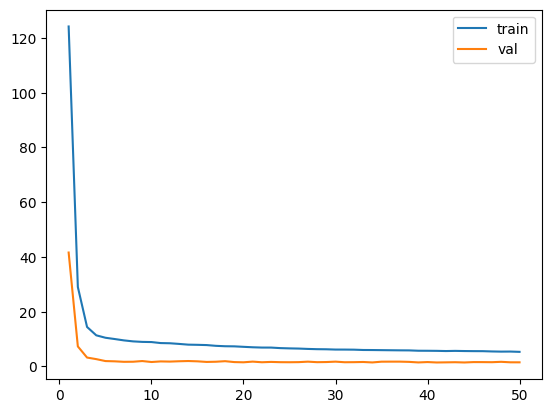

In [26]:
import matplotlib.pyplot as plt

# Assuming 'epochs' is an integer (e.g., 50)
epoch_range = range(1, epochs + 1)  # Create a range of values for the x-axis

plt.plot(epoch_range, train_losses, label='train')
plt.plot(epoch_range, val_losses, label='val')
plt.legend()
plt.show()

In [27]:
val_loss, val_acc = evaluate(
    model, val_loader, criterion, device
)
print(f'Val loss: {val_loss:.4f}')

test_loss, test_acc = evaluate(
    model, test_loader, criterion, device
)
print(f'Test loss: {test_loss:.4f}')

print('Evaluation on val/test dataset')
print('Val accuracy:', val_acc )
print('Test accuracy:', test_acc)

Val loss: 1.5239
Test loss: 1.3266
Evaluation on val/test dataset
Val accuracy: 0.005391394504924832
Test accuracy: 0.006639692914202718


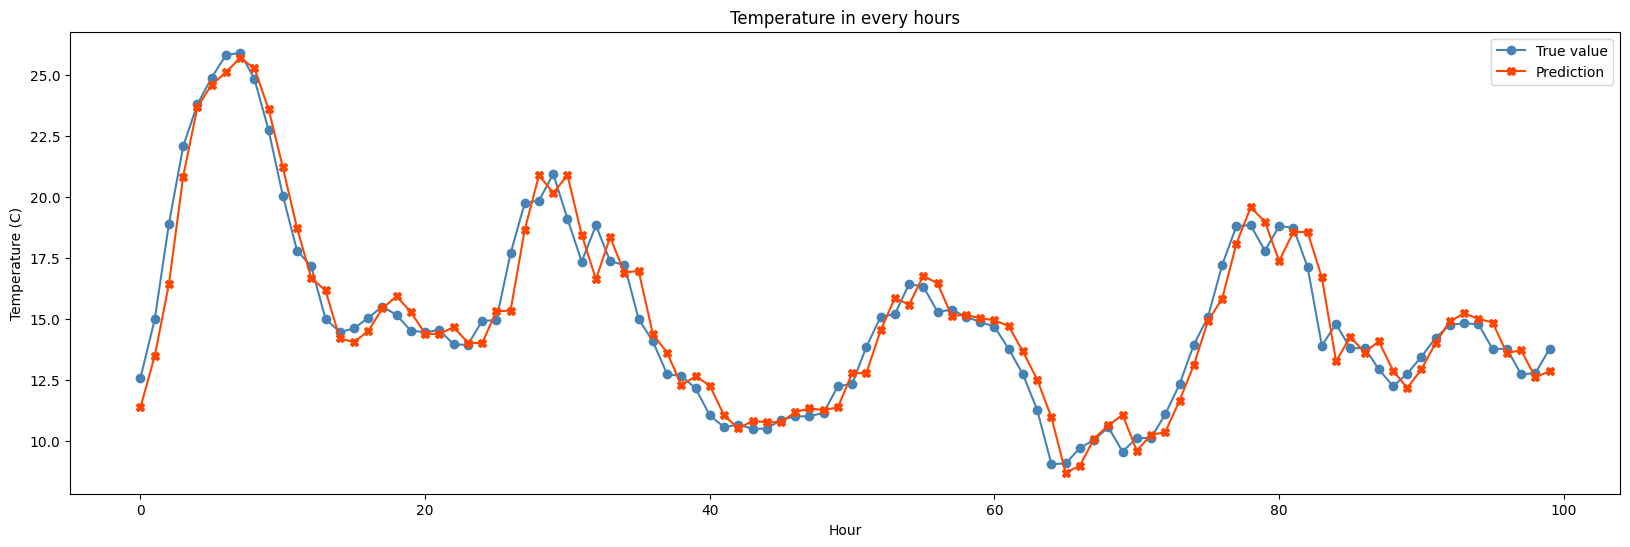

In [29]:
def plot_difference(y, pred):
    plt.figure(figsize=(20, 6))
    times = range(len(y))
    y_to_plot = y.flatten()
    pred_to_plot = pred.flatten()

    plt.plot(times, y_to_plot, color='steelblue', marker='o', label='True value')
    plt.plot(times, pred_to_plot, color='orangered', marker='X', label='Prediction')

    plt.title('Temperature in every hours')
    plt.xlabel('Hour')
    plt.ylabel('Temperature (C)')
    plt.legend()
    plt.show()

inputs = torch.tensor(X_test[:100],
                      dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
    outputs = model(inputs).detach().cpu().numpy()
plot_difference(y_test[:100], outputs)

In [30]:
# Save the model's state dictionary
torch.save(model.state_dict(), 'temperature_forecasting.pt')